In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#store the path of the drug-metabolite file
path = 'C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\Datasets\\4-AMINO-3-PENTADECYLPHENOL_integrated.csv'

In [4]:
#extract the name of the drug

dr = path.split('\\')[-1]
drug_name = dr.split('_')[0]
drug_name

'4-AMINO-3-PENTADECYLPHENOL'

In [5]:
#read the input drug-metabolite integrated data
data = pd.read_csv(path)

In [6]:
data.head(2)

,Cell Line,Acetone ; Propanal ; acetone,Acetaldehyde oxime ; HMDB01122,acetate,Urea,Isopropyl alcohol ; Propyl alcohol,Bicarbonate ; Hydrogen carbonate,Dimethylsulfide,3-Butyn-1-al,1-pyrrolinium,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,Breast_BT549,0.021811,0.006137,1.801231,0.178675,0.031762,0.143416,0.004437,0.001118,0.002353,...,1.93205,3.74886,0.452336,0.940899,2.78817,0.493042,1.21729,36.0483,2.49718,2.30652
1,Breast_HS578T,0.010611,0.006815,0.884542,0.093390,0.016027,0.037372,NaN,0.005778,0.003199,...,1.96807,3.22352,0.157620,0.343406,2.11181,0.135277,1.42039,103.5290,1.27063,1.64715


In [7]:
#drop the target drug column
drug = data.pop(f'{drug_name}')

In [8]:
#read the representative set of metabolites

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\ModelRunNTimes\\outputs\\representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()
    
#read the genes

with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\list_of_genes.txt', 'r+') as f:
     rep_genes = f.read().strip().splitlines()   
     
rep_genes.extend(rep_meta)

In [9]:
len(rep_meta), len(rep_genes)

(197, 24023)

In [10]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#select only the representative metabolites and the gene expression profiles
X = X[rep_genes]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [11]:
X.shape

(52, 24023)

In [12]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [13]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [14]:
X.shape, y.shape

((52, 24023), (52,))

In [15]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

1    30
0    22
dtype: int64

In [16]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [17]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.472811,0.993475,-0.010947,-0.006304,-0.001014,-0.002971,0.064921,0.021742,2.326285,0.162532,...,-1.081216,-1.037543,-0.359879,-1.058063,0.878118,-1.265965,-0.401421,0.373358,-0.678052,1.062383
1,2.071774,0.199297,-0.229005,-0.255555,-0.001014,-0.216719,0.064921,0.021742,-0.915121,4.864877,...,-0.708775,-0.257647,-1.102535,-0.004053,-0.876007,-1.124955,-1.091879,-2.027887,-1.567635,0.699009


In [18]:
X.shape, y.shape

((60, 24023), (60,))

In [19]:
y.value_counts()

0    30
1    30
dtype: int64

In [20]:
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.472811,0.993475,-0.010947,-0.006304,-0.001014,-0.002971,0.064921,0.021742,2.326285,0.162532,...,-1.081216,-1.037543,-0.359879,-1.058063,0.878118,-1.265965,-0.401421,0.373358,-0.678052,1.062383
1,2.071774,0.199297,-0.229005,-0.255555,-0.001014,-0.216719,0.064921,0.021742,-0.915121,4.864877,...,-0.708775,-0.257647,-1.102535,-0.004053,-0.876007,-1.124955,-1.091879,-2.027887,-1.567635,0.699009


In [21]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [22]:
X_train.shape, X_test.shape

((48, 24023), (12, 24023))

In [23]:
y_train.value_counts(), y_test.value_counts()

(0    24
 1    24
 dtype: int64,
 0    6
 1    6
 dtype: int64)

In [24]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features being selected each run
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features.append(len(X_train.columns))
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 565
Number of features selected during iteration 1: 551
Number of features selected during iteration 2: 573
Number of features selected during iteration 3: 557
Number of features selected during iteration 4: 573
Number of features selected during iteration 5: 576
Number of features selected during iteration 6: 578
Number of features selected during iteration 7: 571
Number of features selected during iteration 8: 564
Number of features selected during iteration 9: 555
Number of features selected during iteration 10: 564
Number of features selected during iteration 11: 555
Number of features selected during iteration 12: 557
Number of features selected during iteration 13: 568
Number of features selected during iteration 14: 567
Number of features selected during iteration 15: 553
Number of features selected during iteration 16: 566
Number of features selected during iteration 17: 562
Number of features selected during iteration 18: 568
Num

In [25]:
features = list(X_train_new.columns)
count = 0
for i in features:
    if i in rep_meta:
        count+=1 #get the number of metabolites selected from the represented features
count, len(features) - count #count the number of genes 

(9, 563)

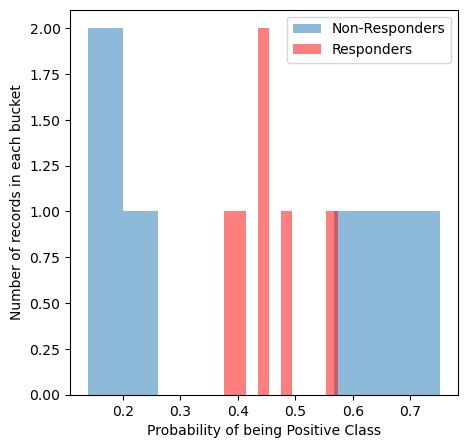

In [26]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [27]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [28]:
df1

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.472811,0.993475,-0.010947,-0.006304,-0.001014,-0.002971,0.064921,0.021742,2.326285,0.162532,...,-0.359879,-1.058063,0.878118,-1.265965,-0.401421,0.373358,-0.678052,1.062383,NaN,NaN
1,2.071774,0.199297,-0.229005,-0.255555,-0.001014,-0.216719,0.064921,0.021742,-0.915121,4.864877,...,-1.102535,-0.004053,-0.876007,-1.124955,-1.091879,-2.027887,-1.567635,0.699009,NaN,NaN
2,-0.553549,-0.906890,-0.318935,-0.256429,-0.001014,-0.360432,0.064921,-0.560631,-1.002081,0.162532,...,0.086412,-0.930616,-0.092136,-1.150986,-0.259816,-0.475436,-0.562191,-0.232326,NaN,NaN
3,2.396681,0.707700,-0.341159,-0.256998,-0.466406,-0.002971,0.064921,-0.372294,-0.690903,0.162532,...,-0.087286,-0.272825,0.388054,0.171099,-0.349999,-0.745624,0.609760,-0.804477,NaN,NaN
4,1.499986,-0.851604,-0.010947,-0.255019,-0.001014,-0.002971,0.064921,-0.280602,-0.928724,0.008744,...,-1.192113,0.224900,-1.598342,1.097647,-2.015206,-0.586804,-1.084451,-0.086782,NaN,NaN
5,0.940189,1.170573,-0.324332,-0.256610,-0.001014,-0.002971,0.064921,-0.547856,-0.881678,0.162532,...,-0.380255,0.436868,0.112173,0.645492,-1.383596,1.117473,0.647182,-1.058979,0.252800,0.0
6,0.645886,0.796776,-0.331005,-0.243662,-0.076562,-0.002971,0.064921,-0.522894,-0.638913,0.162532,...,-0.552516,-0.823372,-0.339200,0.171732,0.163967,-0.770623,-0.394443,1.686013,NaN,NaN
7,0.628814,-0.808022,-0.218348,-0.233642,-0.395387,-0.282201,0.064921,-0.475143,1.413220,3.353750,...,-2.031778,-0.707060,-2.059151,0.770116,-1.599995,-1.189005,-0.999035,-1.398907,NaN,NaN
8,-0.533873,-0.830918,-0.352991,7.322043,7.311860,-0.351322,0.064921,-0.436750,1.785299,-0.577839,...,0.244753,-0.985222,-0.009993,-0.860962,-0.404375,0.098512,0.263693,0.014893,NaN,NaN
9,-0.494638,-0.616738,-0.272817,-0.256469,-0.484495,-0.002971,0.064921,0.021742,0.097178,-1.393092,...,0.084563,-0.996243,0.624836,-0.199922,0.434047,0.069491,0.258032,0.567694,NaN,NaN


In [29]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(0, 24025)

In [30]:
df1_main.index.values #0 40 41 42

array([], dtype=int64)

In [31]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features selected in each iteration
num_features2 = []

#define a list to store accuracy, precision and recall 
model2 = SVC(C=1, gamma=1, probability=True)
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train-test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 554
Features selected during iteration 1: 568
Features selected during iteration 2: 546
Features selected during iteration 3: 573
Features selected during iteration 4: 577
Features selected during iteration 5: 590
Features selected during iteration 6: 572
Features selected during iteration 7: 571
Features selected during iteration 8: 583
Features selected during iteration 9: 553
Features selected during iteration 10: 573
Features selected during iteration 11: 569
Features selected during iteration 12: 571
Features selected during iteration 13: 559
Features selected during iteration 14: 562
Features selected during iteration 15: 561
Features selected during iteration 16: 567
Features selected during iteration 17: 549
Features selected during iteration 18: 554
Features selected during iteration 19: 534
Features selected during iteration 20: 574
Features selected during iteration 21: 560
Features selected during iteration 22: 547
Features selected dur

In [32]:
print(f'Average number of features being selected: {np.mean(num_features2)}')

Average number of features being selected: 563.52


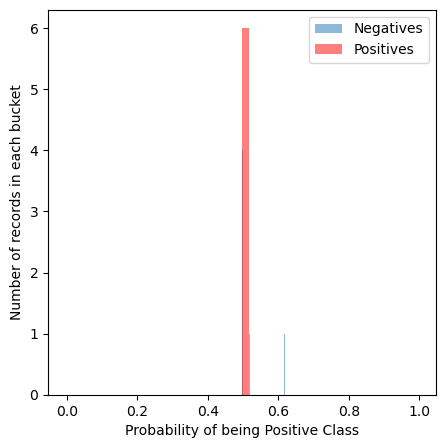

In [33]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [34]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [35]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target


In [36]:
df2_main.index.values #40 41 42

array([], dtype=int64)

In [37]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features being selected in each iteration
num_features3 = []

#define the XGBoost model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 33
Features selected during iteration 1: 33
Features selected during iteration 2: 33
Features selected during iteration 3: 33
Features selected during iteration 4: 33
Features selected during iteration 5: 33
Features selected during iteration 6: 33
Features selected during iteration 7: 33
Features selected during iteration 8: 33
Features selected during iteration 9: 33
Features selected during iteration 10: 33
Features selected during iteration 11: 33
Features selected during iteration 12: 33
Features selected during iteration 13: 33
Features selected during iteration 14: 33
Features selected during iteration 15: 33
Features selected during iteration 16: 33
Features selected during iteration 17: 33
Features selected during iteration 18: 33
Features selected during iteration 19: 33
Features selected during iteration 20: 33
Features selected during iteration 21: 33
Features selected during iteration 22: 33
Features selected during iteration 23: 33
Fe

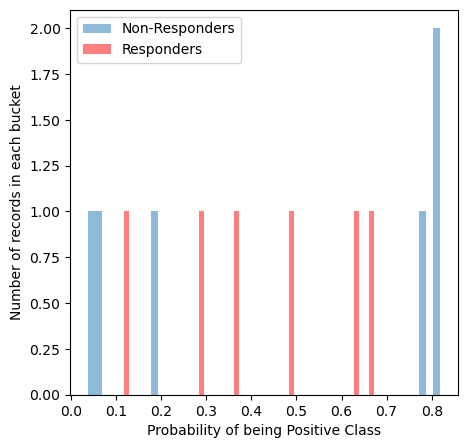

In [38]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [39]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.472811,0.993475,-0.010947,-0.006304,-0.001014,-0.002971,0.064921,0.021742,2.326285,0.162532,...,-0.359879,-1.058063,0.878118,-1.265965,-0.401421,0.373358,-0.678052,1.062383,NaN,NaN
1,2.071774,0.199297,-0.229005,-0.255555,-0.001014,-0.216719,0.064921,0.021742,-0.915121,4.864877,...,-1.102535,-0.004053,-0.876007,-1.124955,-1.091879,-2.027887,-1.567635,0.699009,NaN,NaN
2,-0.553549,-0.906890,-0.318935,-0.256429,-0.001014,-0.360432,0.064921,-0.560631,-1.002081,0.162532,...,0.086412,-0.930616,-0.092136,-1.150986,-0.259816,-0.475436,-0.562191,-0.232326,NaN,NaN
3,2.396681,0.707700,-0.341159,-0.256998,-0.466406,-0.002971,0.064921,-0.372294,-0.690903,0.162532,...,-0.087286,-0.272825,0.388054,0.171099,-0.349999,-0.745624,0.609760,-0.804477,NaN,NaN
4,1.499986,-0.851604,-0.010947,-0.255019,-0.001014,-0.002971,0.064921,-0.280602,-0.928724,0.008744,...,-1.192113,0.224900,-1.598342,1.097647,-2.015206,-0.586804,-1.084451,-0.086782,NaN,NaN
5,0.940189,1.170573,-0.324332,-0.256610,-0.001014,-0.002971,0.064921,-0.547856,-0.881678,0.162532,...,-0.380255,0.436868,0.112173,0.645492,-1.383596,1.117473,0.647182,-1.058979,0.184435,0.0
6,0.645886,0.796776,-0.331005,-0.243662,-0.076562,-0.002971,0.064921,-0.522894,-0.638913,0.162532,...,-0.552516,-0.823372,-0.339200,0.171732,0.163967,-0.770623,-0.394443,1.686013,NaN,NaN
7,0.628814,-0.808022,-0.218348,-0.233642,-0.395387,-0.282201,0.064921,-0.475143,1.413220,3.353750,...,-2.031778,-0.707060,-2.059151,0.770116,-1.599995,-1.189005,-0.999035,-1.398907,NaN,NaN
8,-0.533873,-0.830918,-0.352991,7.322043,7.311860,-0.351322,0.064921,-0.436750,1.785299,-0.577839,...,0.244753,-0.985222,-0.009993,-0.860962,-0.404375,0.098512,0.263693,0.014893,NaN,NaN
9,-0.494638,-0.616738,-0.272817,-0.256469,-0.484495,-0.002971,0.064921,0.021742,0.097178,-1.393092,...,0.084563,-0.996243,0.624836,-0.199922,0.434047,0.069491,0.258032,0.567694,NaN,NaN


In [40]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target


In [41]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [42]:
cl = set(common_list)
cl

set()

In [43]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
14,-0.605420,0.057042,-0.323394,-0.256882,-0.001014,-0.002971,0.064921,-0.484161,0.491103,0.162532,...,-0.021374,0.814701,1.347794,0.734178,0.915595,0.427549,0.739633,0.194610,0.451867,1.0
18,-0.514672,-0.467895,-0.303111,-0.219423,0.436609,-0.002971,0.064921,-0.445155,0.056118,0.162532,...,-0.951192,-0.004053,-0.335598,-2.385540,-2.052177,-1.299301,-0.531419,-0.660214,0.404933,1.0
19,-0.547202,-0.272625,-0.332506,-0.255345,-0.001014,-0.002971,0.064921,0.021742,-0.098866,0.162532,...,-0.446020,0.057807,0.101253,0.931759,-0.106065,-0.318905,-0.862009,1.253316,0.446267,1.0
22,-0.471055,-0.421287,-0.010947,-0.221226,0.043324,-0.002971,0.064921,0.021742,-0.322906,0.162532,...,-1.445491,1.692578,-1.032650,1.168483,-0.714519,-1.133349,-1.773696,-0.622089,0.375467,1.0
28,0.078962,1.310271,-0.345644,1.833464,1.376758,-0.358972,0.064921,0.021742,0.234247,0.162532,...,-0.303951,-0.991552,-0.906694,-1.130931,0.118297,-0.537851,-0.514060,-1.406384,0.573867,1.0
48,-0.558339,-0.010061,-0.329525,-0.257000,-0.400964,-0.357787,0.064921,0.021742,1.347174,-0.562867,...,-0.203223,-0.962997,-0.342948,-1.450078,-0.716733,-0.102858,-0.612357,-0.310636,0.475867,1.0


In [44]:
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\outputs\\master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [45]:
l = []
l.extend(df1_total.index.values)
with open('C:\\Users\\nilav\\Desktop\\NCI Cell Lines\\NCI Cell Lines\\Integrated Analysis with Rep Meta\\outputs\\total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')